In [1]:
from VariationalBayes import ScalarParam, ModelParamsDict, VectorParam, PosDefMatrixParam
from VariationalBayes.NormalParams import MVNParam, UVNParam, UVNParamVector
from VariationalBayes.GammaParams import GammaParam
from VariationalBayes.ExponentialFamilies import \
    UnivariateNormalEntropy, MultivariateNormalEntropy, GammaEntropy, \
    MVNPrior, UVNPrior, GammaPrior


from autograd import grad, hessian, jacobian, hessian_vector_product
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy as asp
import scipy as sp

import copy
from scipy import optimize

In [116]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.
import os
import json

simulate_data = False
prior_par = ModelParamsDict('Prior Parameters')

if not simulate_data:
    analysis_name = 'simulated_data_small'
    data_dir = os.path.join(os.environ['GIT_REPO_LOC'], 'LRVBLogitGLMM/LogitGLMMLRVB/inst/data/')
    json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)
    json_output_filename = os.path.join(data_dir, '%s_python_vb_results.json' % analysis_name)

    json_file = open(json_filename, 'r')
    stan_dat = json.load(json_file)
    json_file.close()

    print stan_dat.keys()
    K = stan_dat['K'][0]
    NObs = stan_dat['N'][0]
    NG = stan_dat['NG'][0]
    N = NObs / NG
    y_g_vec = np.array(stan_dat['y_group'])
    y_vec = np.array(stan_dat['y'])
    x_mat = np.array(stan_dat['x'])
    
    # Define a class to contain prior parameters.
    prior_par.push_param(VectorParam('beta_prior_mean', K, val=np.array(stan_dat['beta_prior_mean'])))
    prior_par.push_param(PosDefMatrixParam('beta_prior_var', K, val=np.array(stan_dat['beta_prior_var'])))

    prior_par.push_param(ScalarParam('mu_prior_mean', val=stan_dat['mu_prior_mean'][0]))
    prior_par.push_param(ScalarParam('mu_prior_var', val=stan_dat['mu_prior_var'][0]))

    prior_par.push_param(ScalarParam('tau_prior_alpha', val=stan_dat['tau_prior_alpha'][0]))
    prior_par.push_param(ScalarParam('tau_prior_beta', val=stan_dat['tau_prior_beta'][0]))

    # An index set to make sure jacobians match the order expected by R.
    prior_par_indices = copy.deepcopy(prior_par)
    prior_par_indices.set_name('Prior Indices')
    prior_par_indices.set_vector(np.array(range(prior_par_indices.vector_size())))
else:
    # Simulate data instead of loading it if you like
    N = 200     # observations per group
    K = 5      # dimension of regressors
    NG = 200      # number of groups

    # Generate data
    def Logistic(u):
        return np.exp(u) / (1 + np.exp(u))

    NObs = NG * N
    true_beta = np.array(range(5))
    true_beta = true_beta - np.mean(true_beta)
    true_mu = 0.
    true_tau = 40.0
    true_u = np.random.normal(true_mu, 1 / np.sqrt(true_tau), NG)

    x_mat = np.random.random(K * NObs).reshape(NObs, K) - 0.5
    y_g_vec = [ g for g in range(NG) for n in range(N) ]
    true_rho = Logistic(np.matmul(x_mat, true_beta) + true_u[y_g_vec])
    y_vec = np.random.random(NObs) < true_rho
    
    prior_par.push_param(VectorParam('beta_prior_mean', K, val=np.zeros(K)))
    prior_par.push_param(PosDefMatrixParam('beta_prior_var', K, val=10 * np.eye(K)))

    prior_par.push_param(ScalarParam('mu_prior_mean', val=0))
    prior_par.push_param(ScalarParam('mu_prior_var', val=2))

    prior_par.push_param(ScalarParam('tau_prior_alpha', val=3.0))
    prior_par.push_param(ScalarParam('tau_prior_beta', val=10.0))


print np.mean(y_vec)

0.49325


In [117]:
# Build an object to contain a variational approximation to a K-dimensional multivariate normal.
glmm_par = ModelParamsDict('GLMM Parameters')

glmm_par.push_param(UVNParam('mu'))
glmm_par.push_param(GammaParam('tau'))
glmm_par.push_param(MVNParam('beta', K))
glmm_par.push_param(UVNParamVector('u', NG))

glmm_par['mu'].mean.set(0.1)
glmm_par['mu'].var.set(1.0)

glmm_par['tau'].shape.set(2.1)
glmm_par['tau'].rate.set(2.1)

glmm_par['beta'].mean.set(np.full(K, 0.))
glmm_par['beta'].cov.set(20 * np.eye(K))

glmm_par['u'].mean.set(np.full(NG, 0.))
glmm_par['u'].var.set(np.full(NG, 1))
    
print N * NG
print glmm_par

40000
GLMM Parameters:
	mu:
mu_mean: 0.1
mu_var: 1.0
	tau:
tau_shape: 2.1
tau_rate: 2.1
	beta:
beta_mean:
[ 0.  0.  0.  0.  0.]
beta_cov:
[[ 20.   0.   0.   0.   0.]
 [  0.  20.   0.   0.   0.]
 [  0.   0.  20.   0.   0.]
 [  0.   0.   0.  20.   0.]
 [  0.   0.   0.   0.  20.]]
	u:
u_mean:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [130]:
def ELogPrior(prior_par, glmm_par_elbo):
    e_beta = glmm_par_elbo['beta'].mean.get()
    cov_beta = glmm_par_elbo['beta'].cov.get()
    beta_prior_info = np.linalg.inv(prior_par['beta_prior_var'].get())
    beta_prior_mean = prior_par['beta_prior_mean'].get()
    e_log_p_beta = MVNPrior(beta_prior_mean, beta_prior_info, e_beta, cov_beta)
    
    e_mu = glmm_par_elbo['mu'].mean.get()
    var_mu = glmm_par_elbo['mu'].var.get()
    e_log_p_mu = UVNPrior(prior_par['mu_prior_mean'].get(), 1 / prior_par['mu_prior_var'].get(), e_mu, var_mu) 

    e_tau = glmm_par_elbo['tau'].e()
    e_log_tau = glmm_par_elbo['tau'].e_log()
    tau_prior_shape = prior_par['tau_prior_alpha'].get()
    tau_prior_rate = prior_par['tau_prior_beta'].get()
    e_log_p_tau = GammaPrior(tau_prior_shape, tau_prior_rate, e_tau, e_log_tau)
    
    return  e_log_p_beta + e_log_p_mu + e_log_p_tau
           

def DataLogLikelihood(x_mat, y_vec, e_beta, cov_beta, e_u, var_u, std_draws):
    z_mean = e_u + np.matmul(x_mat, e_beta)
    z_sd = np.sqrt(var_u + np.einsum('nk,kj,nj->n', x_mat, cov_beta, x_mat))
    z = np.einsum('i,j->ij', z_sd, std_draws) + np.expand_dims(z_mean, 1)

    # The sum is over observations and draws, so dividing by the draws size
    # gives the sum of sample expectations over the draws.
    # p = exp(z) / (1 + exp(z))
    # log(1 - p) = log(1 / (1 + exp(z))) = -log(1 + exp(z))
    logit_term = -np.sum(np.log1p(np.exp(z))) / std_draws.size
    y_term = np.sum(y_vec * z_mean)
    return y_term + logit_term


def RandomEffectLogLikelihood(e_u, var_u, e_mu, var_mu, e_tau, e_log_tau):
    return -0.5 * e_tau * np.sum(((e_mu - e_u) ** 2) + var_mu + var_u) + 0.5 * e_log_tau * len(e_u)

    
def Elbo(y_vec, x_mat, y_g_vec, glmm_par_elbo, std_draws, prior_par):
    e_beta = glmm_par_elbo['beta'].mean.get()
    cov_beta = glmm_par_elbo['beta'].cov.get()
    
    e_u = glmm_par_elbo['u'].mean.get()
    var_u = glmm_par_elbo['u'].var.get()
    
    e_mu = glmm_par_elbo['mu'].mean.get()
    var_mu = glmm_par_elbo['mu'].var.get()
    
    e_tau = glmm_par_elbo['tau'].e()
    e_log_tau = glmm_par_elbo['tau'].e_log()
    
    ll = \
        DataLogLikelihood(x_mat, y_vec, e_beta, cov_beta,
                          e_u[y_g_vec], var_u[y_g_vec], std_draws) + \
        RandomEffectLogLikelihood(e_u, var_u, e_mu, var_mu, e_tau, e_log_tau)

    e_log_prior = ELogPrior(prior_par, glmm_par_elbo)
    
    tau_shape = glmm_par_elbo['tau'].shape.get()
    tau_rate = glmm_par_elbo['tau'].rate.get()
    entropy = \
        UnivariateNormalEntropy(var_mu) + \
        MultivariateNormalEntropy(cov_beta) + \
        UnivariateNormalEntropy(var_u) + \
        GammaEntropy(tau_shape, tau_rate)

    return ll[0] + e_log_prior[0] + entropy


class KLWrapper():
    def __init__(self, glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_draws):
        self.__glmm_par_ad = copy.deepcopy(glmm_par)
        self.__prior_par_ad = copy.deepcopy(prior_par)
        self.x_mat = x_mat
        self.y_vec = y_vec
        self.y_g_vec = y_g_vec
        draw_spacing = 1 / float(num_draws + 1)
        target_quantiles = np.linspace(draw_spacing, 1 - draw_spacing, num_draws)
        self.std_draws = sp.stats.norm.ppf(target_quantiles)

    def Eval(self, free_par_vec, verbose=False):
        self.__glmm_par_ad.set_free(free_par_vec)
        kl = -Elbo(self.y_vec, self.x_mat, self.y_g_vec,
                   self.__glmm_par_ad, self.std_draws, self.__prior_par_ad)
        if verbose: print kl
            
        # TODO: this is returning an array when it should be a scalar.
        return kl

    # Return a posterior moment of interest as a function of
    # unconstrained parameters.  In this case it is a bit silly,
    # but in full generality posterior moments may be a complicated
    # function of moment parameters.
    def GetMoments(self, free_par_vec):
        self.__glmm_par_ad.set_free(free_par_vec)
        return self.__glmm_par_ad['beta'].mean.get()


kl_wrapper = KLWrapper(glmm_par, prior_par, x_mat, y_vec, y_g_vec, 10)
KLGrad = grad(kl_wrapper.Eval)
KLHess = hessian(kl_wrapper.Eval)
MomentJacobian = jacobian(kl_wrapper.GetMoments)
KLHessVecProd = hessian_vector_product(kl_wrapper.Eval)  
free_par_vec = glmm_par.get_free()
kl_wrapper.Eval(free_par_vec)

48461.222808041595

In [131]:
import timeit

time_num = 10

print 'Function time:'
print timeit.timeit(lambda: kl_wrapper.Eval(free_par_vec), number=time_num) / time_num

print 'Grad time:'
print timeit.timeit(lambda: KLGrad(free_par_vec), number=time_num) / time_num

print 'Hessian vector product time:'
print timeit.timeit(lambda: KLHessVecProd(free_par_vec, free_par_vec + 1), number=time_num) / time_num

# so slow
# print 'Hessian time:'
# print timeit.timeit(lambda: KLHess(free_par_vec), number=time_num) / time_num


Function time:
0.0322784900665
Grad time:
0.0741811037064
Hessian vector product time:
0.155743908882


In [132]:
import time

init_par_vec = free_par_vec

# Optimize.
vb_time = time.time()
print 'Running BFGS'
vb_opt_bfgs = optimize.minimize(
    lambda par: kl_wrapper.Eval(par, verbose=True), init_par_vec,
    method='bfgs', jac=KLGrad, tol=1e-2, options={'maxiter': 5000, 'disp': True})

init_par_vec = free_par_vec
print 'Running Newton Trust Region'
vb_opt = optimize.minimize(
    lambda par: kl_wrapper.Eval(par, verbose=True),
    vb_opt_bfgs.x, method='trust-ncg', jac=KLGrad, hessp=KLHessVecProd, options={'maxiter': 5000, 'disp': True})

vb_time = time.time() - vb_time

glmm_par_opt = copy.deepcopy(glmm_par)
glmm_par_opt.set_free(vb_opt.x)
print 'Done.'

print vb_time / 60

Running BFGS
48461.222808
44869.6782262
33592.5884906
70205.1514196
29694.3410593
54209.2654163
29329.7137655
28683.5975606
28145.2039792
27396.6364833
27951.9351582
27117.4476528
29380.5867154
27088.1513177
27033.6605193
26928.7611222
26611.2869081
25923.8984847
27390.9255598
25774.26598
26066.8216056
25736.4877088
25669.8441113
25803.5882565
25653.0257552
25622.6808643
25566.0907483
25533.4684842
25468.975517
25239.0912223
26278.5821466
25186.3181258
25107.2291289
25319.281519
25091.9385601
25110.5017728
25088.8411024
25082.6080832
25058.1520001
24967.901708
25105.1931397
24929.4086863
24867.5382326
24983.3075321
24851.3524942
24821.3278782
24857.3279804
24812.2854375
24795.2946934
24762.3613106
24657.7473677
25525.2331081
24642.7401997
24619.8659141
24701.2842191
24616.5663929
24609.9734326
24585.0674613
24570.5627005
24542.6738455
24458.7100994
25358.221379
24447.6472169
24427.2361503
24459.1657873
24421.3914054
24410.2003616
24415.3786717
24405.5969766
24396.7416563
24369.9008939


In [135]:
# print(glmm_par_opt)
print true_beta
print glmm_par_opt['beta']
print '---------------\n'
print true_tau
print glmm_par_opt['tau'].e()

e_u = glmm_par_opt['u'].e()
var_u = glmm_par_opt['u'].var.get()
e_beta = glmm_par_opt['beta'].e()
e_beta_outer = glmm_par_opt['beta'].e_outer()
std_draws = kl_wrapper.std_draws

rho_mean = e_u[y_g_vec] + np.matmul(x_mat, e_beta)
rho_sd = np.sqrt(var_u[y_g_vec] + np.einsum('nk,kj,nj->n', x_mat, e_beta_outer, x_mat))
z = np.einsum('i,j->ij', rho_sd, std_draws) + np.expand_dims(rho_mean, 1)
logit_term = -np.einsum('ij->i', np.log1p(np.exp(z))) / std_draws.size

print rho_sd
print var_u[y_g_vec]
# print np.mean(var_u)


[-2. -1.  0.  1.  2.]
beta:
beta_mean:
[-1.99474187 -1.0491084  -0.05320961  1.0467047   1.95504657]
beta_cov:
[[  2.48289135e-03   1.84537918e-04   7.27582229e-06  -1.71048636e-04
   -3.23560814e-04]
 [  1.84537918e-04   2.36145421e-03  -1.06263609e-05  -9.37816387e-05
   -1.43468754e-04]
 [  7.27582229e-06  -1.06263609e-05   2.30824215e-03   5.02887319e-06
   -3.76715488e-05]
 [ -1.71048636e-04  -9.37816387e-05   5.02887319e-06   2.35454288e-03
    1.68523791e-04]
 [ -3.23560814e-04  -1.43468754e-04  -3.76715488e-05   1.68523791e-04
    2.46284028e-03]]
---------------

40.0
[ 6.26710633]
[ 0.63159208  0.79348849  0.37270581 ...,  1.25067785  1.86952295
  0.42580882]
[ 0.030702    0.030702    0.030702   ...,  0.03012714  0.03012714
  0.03012714]


[-0.03240305]
0.0
[ 6.26710633]
40.0


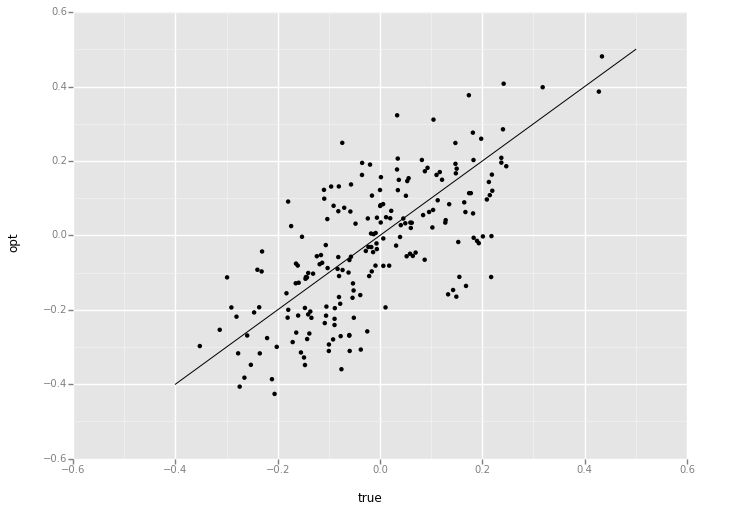

<ggplot: (8774630966517)>


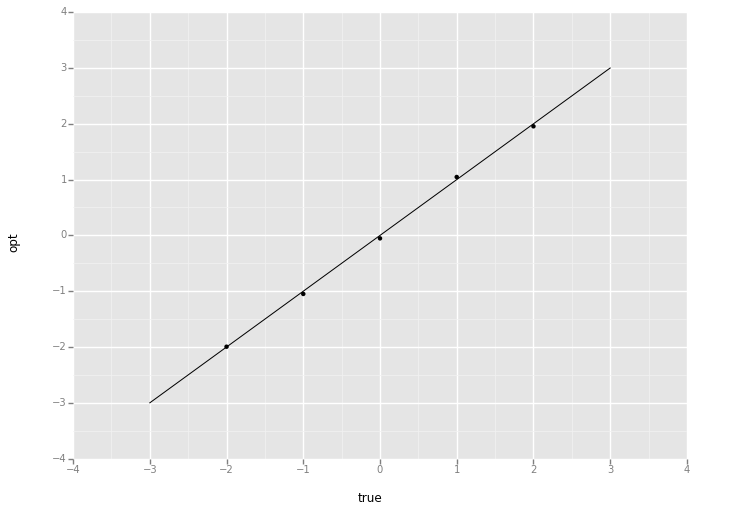

<ggplot: (8774630966433)>


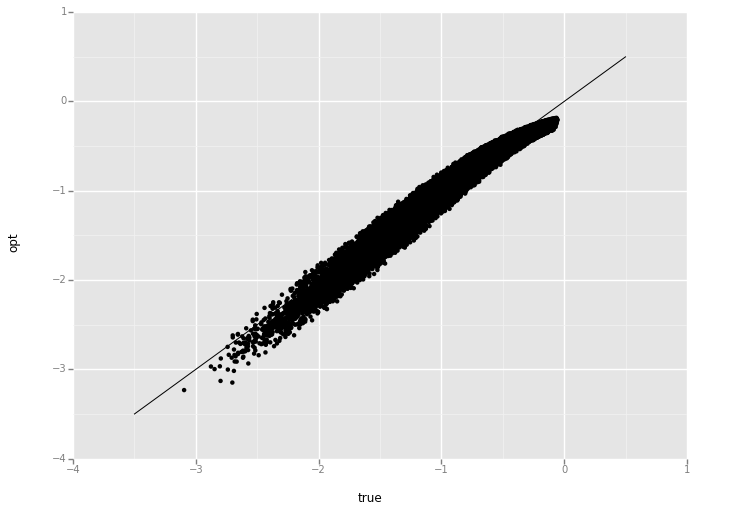

<ggplot: (8774630966477)>


In [137]:
# Check the random effect estimates.  This requires simulated data.
if simulate_data:
    from ggplot import *
    import pandas as pd
    %matplotlib inline
    
    print glmm_par_opt['mu'].e()
    print true_mu

    print glmm_par_opt['tau'].e()
    print true_tau

    plot_df = pd.DataFrame({ 'opt': glmm_par_opt['u'].mean.get(), 'true': true_u })
    print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)
    
    plot_df = pd.DataFrame({ 'opt': glmm_par_opt['beta'].mean.get(), 'true': true_beta })
    print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)
    
    plot_df = pd.DataFrame({ 'opt': logit_term, 'true': np.log(1 - true_rho) })
    print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)

In [13]:
# LRVB with conjugate gradient
from scipy.sparse.linalg import LinearOperator
import sys

# The we will actually compute Hess^1 * moment_jac.T, leading to perhaps confusing
# naming of "columns".  
moment_jac = MomentJacobian(vb_opt.x)
ObjHessVecProdLO = LinearOperator((vb_opt.x.size, vb_opt.x.size), lambda par: KLHessVecProd(vb_opt.x, par))
# print moment_jac.T.shape
# print ObjHessVecProdLO.shape
# cg_res, info = scipy.sparse.linalg.cg(ObjHessVecProdLO, moment_jac.T)

cg_time = timeit.timeit()
lrvb_term = np.full(moment_jac.T.shape, float('nan'))
for col in range(moment_jac.shape[0]):
    sys.stdout.write('.')
    sys.stdout.flush()
    cg_res, info = sp.sparse.linalg.cg(ObjHessVecProdLO, moment_jac[col, :])
    assert info == 0
    lrvb_term[:, col] = cg_res
cg_time = timeit.timeit() - cg_time

print 'all done dude'

.....all done dude


In [14]:
# Slow, but maybe faster than using CG.
hess_time = timeit.timeit()
kl_hess = KLHess(vb_opt.x)
hess_time =  timeit.timeit() - hess_time

In [15]:
print kl_hess[:,:].shape
print moment_jac.shape

beta_cov_hess = np.matmul(moment_jac, np.linalg.solve(kl_hess[:, :], moment_jac.T))
beta_cov = np.matmul(moment_jac, lrvb_term)
print np.diag(beta_cov)
print np.diag(beta_cov_hess)
print np.diag(glmm_par_opt['beta'].cov.get())

(224, 224)
(5, 224)
[ 0.01968077  0.0199127   0.02947166  0.0278251   0.03439231]
[ 0.01968077  0.0199127   0.02947166  0.0278251   0.03439231]
[ 0.03307707  0.03099166  0.04033834  0.03494382  0.03577844]


In [16]:
if not simulated_data:
    result_dict = { 'glmm_par_opt': glmm_par_opt.dictval(), 'vb_time': vb_time }

    result_json = json.dumps(result_dict)
    json_file = open(json_output_filename, 'w')
    json_file.write(result_json)
    json_file.close()

    print(json_output_filename)



/home/rgiordan/Documents/git_repos/LRVBLogitGLMM/LogitGLMMLRVB/inst/data/simulated_data_small_python_vb_results.json
